# 0. Notes:

This notebook determines vessels that transited Suez Canal in 2019 using AIS data. The results are compared against official data from Suez Canal. 

Connect to the UN Global Platform and use kernel `pyspark3.5 ais2.9`

# 1. Preparation

In [1]:
import geopandas as gpd
from shapely.geometry import mapping, Polygon

from pyspark.sql import functions as F
from pyspark.sql import Window as W
from ais import functions as af
import h3.api.numpy_int as h3int

import matplotlib.pyplot as plt

generated new fontManager


In [2]:
from sedona.spark import *

sedona = SedonaContext.create(spark)

Skipping SedonaKepler import, verify if keplergl is installed
Skipping SedonaPyDeck import, verify if pydeck is installed


In [3]:
import requests
import base64
import os
import pandas as pd
from io import StringIO

In [4]:
#change the unique prefix to create your own unique storage path
unique_prefix = "cherryl"

passageway = "suez_canal"
raw_ais_save_path = os.environ["USER_TEMP_S3PATH"] + f"{unique_prefix}/ais_passageways/{passageway}/ais/"

# 2. Geometries

In [5]:
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/{passageway}.geojson")
gdf = gpd.read_file(base64.b64decode(request.json()['content']).decode('utf-8'))
gdf

,Label,POI,geometry
0,North Anchorage,North,"POLYGON ((32.37009 31.32180, 32.57678 31.32166..."
1,Great Bitter Lake,Middle,"POLYGON ((32.28697 30.34816, 32.31222 30.28512..."
2,South Anchorage,South,"POLYGON ((32.52850 29.93424, 32.48518 29.92898..."


Input polygon is too small to be filled in with hexagon of resolution: 4
Attempting to fit a hex of resolution: 5...
A hex of resolution: 5 fits the input polygon
Finding it's parent in resolution: 4
Input polygon is too small to be filled in with hexagon of resolution: 4
Attempting to fit a hex of resolution: 5...
A hex of resolution: 5 fits the input polygon
Finding it's parent in resolution: 4

H3 count:19


<Axes: >

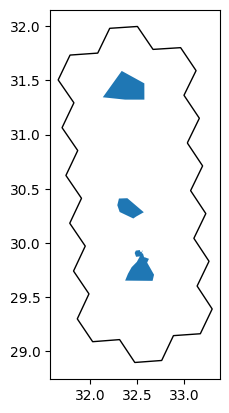

In [6]:
#We use H3 indices (https://h3geo.org/docs) as a geo-spatial filter for AIS data in the UNGP. 
#To get all AIS data within the AOIs, we overfill the geometries with H3 indices, then use the list of H3 indices as filter.  
#To ensure that the filtering is efficient, the number of H3 indices should small and the area outside of the AOI should also be small
#here, we chose H3 index resolution 4. 

h3_resolution = 4

inputs = [(row['POI'], mapping(row['geometry'])) for index, row in gdf.iterrows()]
hex_df = af.polygon_to_hex_df(inputs, h3_resolution, overfill=True)
hexes = hex_df['hex_id'].drop_duplicates().tolist()

print(f"\nH3 count:{len(hexes)}")
hexes = hex_df['hex_id'].drop_duplicates().tolist()
h3_gdf = gpd.GeoDataFrame([["H3",Polygon(h3int.h3_set_to_multi_polygon(hexes, geo_json=True)[0][0])]], columns=['h3','geometry'], crs=4326)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
h3_gdf.plot(ax=ax, facecolor="none")

# 3. Extract AIS data and save to S3

## 3.1 Preparation

In [7]:
ais_cols = [
 'mmsi',
 'longitude',
 'latitude',
 'imo',
 'vessel_name',
 'vessel_type',
 'destination',
 'sog',
 'nav_status',
 'dt_pos_utc',
 'draught']

In [8]:
#Read Ship Register datasets as a spark dataframe, use version 20210609 which is the earliest version available in UNGP
#note that af module is from the ais package 

#The ShipData table provides information on the vessel's IMO, vessel type described by the StatCode5 and ShiptypeLevel5
ihs = af.read_ihs_table(spark, "ShipData.CSV", version="20210609") \
.select("ShipName","LRIMOShipNo","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5", "Draught","Deadweight","GrossTonnage","NetTonnage")

#We use the tblShipTypeCodes table to get more information on the vessel type.
#We select only "Cargo-carrying vessels" which is identified by ShiptypeLevel2 information
ihs_statcode = af.read_ihs_table(spark, "tblShipTypeCodes.CSV",  version="20210609") \
.select("StatCode5","ShiptypeLevel2") \
.filter(F.col("ShiptypeLevel2").isin(["Bulk Carriers", "Dry Cargo/Passenger", "Tankers"]))

In [9]:
#Convert geometries to spark dataframe to prepare for spark processing of geospatial data
sdf_poly = sedona.createDataFrame(gdf[['geometry','POI']])

In [10]:
def extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="overwrite"):
    #Read AIS within the start date and end date where hex ids are within the hexes list
    sdf = af.get_ais(spark, start_date=start_date, end_date=end_date, h3_list = hexes)
    
    #Get only AIS where location is within the POI geometries
    sdf_w_point = sdf.withColumn("point", F.expr("ST_Point(longitude, latitude)"))
    sdf_w_point.createOrReplaceTempView("ais_temp")
    sdf_poly.createOrReplaceTempView("poly_temp")
    sdf_poly_filter = spark.sql(""" select  * from ais_temp, poly_temp where ST_Within(point, geometry)""")
    
    #Get only AIS where the type is cargo related
    sdf_cargo = sdf_poly_filter.join(ihs.withColumnsRenamed({"LRIMOShipNo":"imo",'Draught':'DesignDraught'}), how="inner", on=['imo']) \
    .join(ihs_statcode, how="inner", on=['StatCode5']) \
    .select(*ais_cols, *ihs.drop("LRIMOShipNo").withColumnRenamed("Draught","DesignDraught").columns, "POI") \
    .withColumns({"year":F.year("dt_pos_utc"),"month":F.month("dt_pos_utc")})
    
    #Save in S3
    sdf_cargo.write.mode(mode).partitionBy("year","month").parquet(raw_ais_save_path)
    return sdf_cargo

## 3.2 Run

In [11]:
# #The code is run per month

# start_date = "2019-01-01"
# end_date = "2019-01-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="overwrite")

In [12]:
# start_date = "2019-02-01"
# end_date = "2019-02-28"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [13]:
# start_date = "2019-03-01"
# end_date = "2019-03-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [14]:
# start_date = "2019-04-01"
# end_date = "2019-04-30"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [15]:
# start_date = "2019-05-01"
# end_date = "2019-05-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [16]:
# start_date = "2019-06-01"
# end_date = "2019-06-30"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [17]:
# start_date = "2019-07-01"
# end_date = "2019-07-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [18]:
# start_date = "2019-08-01"
# end_date = "2019-08-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [19]:
# start_date = "2019-09-01"
# end_date = "2019-09-30"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [20]:
# start_date = "2019-10-01"
# end_date = "2019-10-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [21]:
# start_date = "2019-11-01"
# end_date = "2019-11-30"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [22]:
# start_date = "2019-12-01"
# end_date = "2019-12-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

# 4. Get transits

## 4.1 Preparation

In [14]:
w = W.partitionBy("imo").orderBy("dt_pos_utc")
def get_transits(sdf, min_time_diff):
    #This function identifies the "voyages" of a vessel
    #The voyage groups together consecutive messages that likely came from a single transit through the Suez canal
    #A message is identified to have come from a different voyage is the time between the messages is at least a defined time period
    sdf_groups = sdf.withColumn("prev_dt_pos_utc", F.lag("dt_pos_utc").over(w)) \
    .withColumn("time_diff_hours", (F.col("dt_pos_utc").cast("long") - F.col("prev_dt_pos_utc").cast("long")) / 3600) \
    .withColumn("time_diff_flag", F.when(F.col("time_diff_hours").isNull(), 1) \
                                    .when(F.col("time_diff_hours") > min_time_diff,1) \
                                    .otherwise(0)) \
    .withColumn("voyage", F.sum("time_diff_flag").over(w)) \
    .withColumn("idle_hours", F.when(F.col("sog") < 1, F.col("time_diff_hours")).otherwise(0))
    
    #get important information from the voyages needed to identify transits and produce statistics
    transits_sdf = sdf_groups \
    .groupBy("imo","voyage") \
    .agg(F.first("vessel_name").alias("vessel_name"),
         F.first("StatCode5").alias("StatCode5"),
         F.first("ShiptypeLevel5").alias("ShiptypeLevel5"),
         F.first("NetTonnage").alias("NetTonnage"),
         F.min("dt_pos_utc").alias("arrival_date"),
         F.max("dt_pos_utc").alias("departure_date"),
         F.min_by("POI", "dt_pos_utc").alias("arrival_POI"),
         F.max_by("POI", "dt_pos_utc").alias("departure_POI"),
         F.countDistinct("POI").alias("count_distinct_POI"),
         F.sum("idle_hours").alias("idle_time")
        ) \
    .filter(F.col("arrival_POI")!=F.col("departure_POI")) \
    .withColumn("dwell_time",  (F.col("departure_date").cast("long") - F.col("arrival_date").cast("long")) / 3600) \
    .withColumn("direction",     F.concat(F.col("arrival_POI"), F.lit("-"), F.col("departure_POI"))) \
    .withColumn("complete_transit_flag", F.col("direction").isin(['North-South','South-North'])) 
    
    return transits_sdf

## 4.2 Run

In [15]:
#Read the extracted data from Section 3
sdf = spark.read.parquet(raw_ais_save_path + "year=2019/")
print(f"Total AIS messages: {sdf.count():,}")
sdf.show(n=1, truncate=False, vertical =True)

Total AIS messages: 3,189,213
-RECORD 0---------------------------------------------------------
 mmsi                                    | 671659000              
 longitude                               | 32.52384166666667      
 latitude                                | 29.797431666666668     
 imo                                     | 7041053                
 vessel_name                             | PACIFIC M              
 vessel_type                             | Cargo                  
 destination                             | ELAQABA/JO             
 sog                                     | 10.6                   
 nav_status                              | Under Way Using Engine 
 dt_pos_utc                              | 2019-07-03 16:17:35    
 draught                                 | 5.4                    
 ShipName                                | PACIFIC M              
 MaritimeMobileServiceIdentityMMSINumber | 671659000              
 StatCode5                      

In [16]:
# #Identify transits, using minimum time input of 16 hrs. 
transits_df =  get_transits(sdf, 16).toPandas()
transits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17824 entries, 0 to 17823
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   imo                    17824 non-null  int32         
 1   voyage                 17824 non-null  int64         
 2   vessel_name            17824 non-null  object        
 3   StatCode5              17824 non-null  object        
 4   ShiptypeLevel5         17824 non-null  object        
 5   NetTonnage             17824 non-null  int32         
 6   arrival_date           17824 non-null  datetime64[ns]
 7   departure_date         17824 non-null  datetime64[ns]
 8   arrival_POI            17824 non-null  object        
 9   departure_POI          17824 non-null  object        
 10  count_distinct_POI     17824 non-null  int64         
 11  idle_time              17824 non-null  float64       
 12  dwell_time             17824 non-null  float64       
 13  d

## 4.3 Additional Calculated Columns

In [17]:
#Read the vessel type mapping between IHS and SCA vessel types. Note that the mapping was done by the authors based on available information from the two sources
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/IHS SCA Vessel Category Mapping.csv")
mapping = pd.read_csv(StringIO(base64.b64decode(request.json()['content']).decode('utf-8')))
mapping.head()

,StatCode5,ShiptypeLevel2,ShiptypeLevel5,SCA Vessel Type
0,A11A2TN,Tankers,LNG Tanker,LNG Ships
1,A11A2TZ,Tankers,Combination Gas Tanker (LNG/LPG),LNG Ships
2,A11B2TG,Tankers,LPG Tanker,Tankers
3,A11B2TH,Tankers,LPG/Chemical Tanker,Tankers
4,A12A2LP,Tankers,Molten Sulphur Tanker,Tankers


In [18]:
#Determine SCA vessel type to vessel transits
transits_df["SCA_Vessel_Type"] = transits_df['StatCode5'].map(mapping.set_index("StatCode5")["SCA Vessel Type"])
transits_df["ShiptypeLevel2"] = transits_df['StatCode5'].map(mapping.set_index("StatCode5")["ShiptypeLevel2"])

In [19]:
#Each row of the output is a vessel transit. 
transits_df.head()

,imo,voyage,vessel_name,StatCode5,ShiptypeLevel5,NetTonnage,arrival_date,departure_date,arrival_POI,departure_POI,count_distinct_POI,idle_time,dwell_time,direction,complete_transit_flag,SCA_Vessel_Type,ShiptypeLevel2
0,7022356,1,KENOZ,A38A2GL,Livestock Carrier,4067,2019-09-07 12:52:08,2019-09-09 05:39:30,North,South,2,27.667778,40.789444,North-South,True,General Cargo,Dry Cargo/Passenger
1,7022356,5,KENOZ,A38A2GL,Livestock Carrier,4067,2019-12-07 16:55:42,2019-12-08 05:11:24,Middle,South,2,7.475000,12.261667,Middle-South,False,General Cargo,Dry Cargo/Passenger
2,7113624,1,MARIONA,A38A2GL,Livestock Carrier,996,2019-12-17 11:31:49,2019-12-18 18:14:39,North,South,2,0.000000,30.713889,North-South,True,General Cargo,Dry Cargo/Passenger
3,7113624,2,MARIONA,A38A2GL,Livestock Carrier,996,2019-12-25 12:59:16,2019-12-27 11:23:29,South,North,3,21.678889,46.403611,South-North,True,General Cargo,Dry Cargo/Passenger
4,7218395,1,BOUDICCA,A37A2PC,Passenger/Cruise,11714,2019-01-31 17:43:19,2019-02-01 13:51:53,South,North,3,7.203056,20.142778,South-North,True,Passenger Ships,Dry Cargo/Passenger


# 5. Statistics

## 5.1 Count of Transit

In [20]:
n = transits_df[~transits_df['complete_transit_flag'] ].shape[0] / transits_df.shape[0]
print(f"""
Total Transits: {transits_df.shape[0]:,}
Complete Transits: {transits_df['complete_transit_flag'].sum():,}
Additional Transits due to Redundancy: {n*100:.2f}%
""")


Total Transits: 17,824
Complete Transits: 16,431
Additional Transits due to Redundancy: 7.82%



In [21]:
count_per_poi = transits_df.groupby("ShiptypeLevel2") \
.agg({'complete_transit_flag':'sum', 'imo':'count'}) \
.rename(columns={'complete_transit_flag':'North/South', 'imo':'North/South/Middle'})
count_per_poi['% increase'] = 100*((count_per_poi['North/South/Middle'] - count_per_poi['North/South']) / count_per_poi['North/South'])
count_per_poi

#Count of Transits According to Vessel Type and POIs captured

,North/South,North/South/Middle,% increase
ShiptypeLevel2,,,
Bulk Carriers,3886,4073,4.812146
Dry Cargo/Passenger,6974,8021,15.012905
Tankers,5571,5730,2.854066


## 5.2 Comparison with SCA Statistics

In [24]:
#Read the transit statistics from Suez Canal Authority
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/Suez Canal Transits SCA 2019.csv?ref=dev")
sca = pd.read_csv(StringIO(base64.b64decode(request.json()['content']).decode('utf-8')))
sca.head()

,Date,Vessel Type,Status,Transit Count,Net Tonnage
0,01/01/2019,Tankers,Laden,352,14822
1,01/01/2019,LNG Ships,Laden,25,2729
2,01/01/2019,Bulk Carrier,Laden,247,9319
3,01/01/2019,General Cargo,Laden,111,1169
4,01/01/2019,Container Ships,Laden,451,52645


In [52]:
#Transit Counts
transits_stats = transits_df.groupby([pd.Grouper(key="arrival_date", freq="M"), "SCA_Vessel_Type"])["imo"].count().unstack()
transits_stats

SCA_Vessel_Type,Bulk Carrier,Car Carrier,Container Ships,General Cargo,LNG Ships,Passenger Ships,RoRo,Tankers
arrival_date,,,,,,,,
2019-01-31,293,70,465,108,52,12,21,437
2019-02-28,262,72,430,103,46,8,21,369
2019-03-31,298,75,434,119,52,10,21,455
2019-04-30,305,85,446,128,51,18,19,389
2019-05-31,302,64,456,127,70,12,18,405
2019-06-30,275,74,444,142,68,2,19,390
2019-07-31,357,73,466,136,74,1,18,374
2019-08-31,405,80,470,146,69,1,23,400
2019-09-30,399,60,438,95,62,2,14,408


In [53]:
sca[sca['Vessel Type']!="Others"].groupby(['Date','Vessel Type'])['Transit Count'].sum().unstack()

Vessel Type,Bulk Carrier,Car Carrier,Container Ships,General Cargo,LNG Ships,Passenger Ships,RoRo,Tankers
Date,,,,,,,,
01/01/2019,307,70,458,125,47,11,16,450
01/02/2019,264,70,437,103,43,9,15,377
01/03/2019,314,76,447,127,57,9,24,477
01/04/2019,321,87,450,124,56,21,17,414
01/05/2019,316,71,484,130,74,12,21,428
01/06/2019,278,72,449,135,71,2,22,388
01/07/2019,359,72,464,133,78,1,16,379
01/08/2019,416,78,475,146,70,1,22,420
01/09/2019,404,62,432,92,65,2,14,412


In [54]:
#To get the outputs for  local storage
af.create_download_link(transits_stats, "Suez Canal Monthly Transits 2019 using AIS.csv","Suez Canal Monthly Transits 2019 using AIS.csv")

In [58]:
#Net Tonnage
transits_stats = transits_df.groupby([pd.Grouper(key="arrival_date", freq="M"), "SCA_Vessel_Type"])["NetTonnage"].sum().unstack() / 1000
transits_stats

SCA_Vessel_Type,Bulk Carrier,Car Carrier,Container Ships,General Cargo,LNG Ships,Passenger Ships,RoRo,Tankers
arrival_date,,,,,,,,
2019-01-31,6963.883,1495.883,28793.321,606.471,1794.490,161.161,181.697,11408.733
2019-02-28,6185.218,1490.080,26246.266,605.176,1651.662,16.682,209.126,9863.092
2019-03-31,6838.529,1590.769,26794.797,732.808,1950.328,357.400,138.759,11199.683
2019-04-30,7094.617,1822.327,27101.207,773.558,2023.051,931.108,183.118,10429.311
2019-05-31,7026.793,1351.084,28680.780,693.926,2744.543,263.875,180.544,11048.018
2019-06-30,6659.547,1523.657,27769.732,799.270,2628.142,58.608,180.875,10717.393
2019-07-31,9367.089,1541.513,29115.685,819.284,2875.682,4.484,180.731,10407.539
2019-08-31,9803.249,1621.347,29502.799,799.272,2592.437,37.559,204.797,10133.156
2019-09-30,9391.971,1273.255,27426.646,520.960,2431.592,12.952,112.148,10785.807


In [59]:
sca[sca['Vessel Type']!="Others"].groupby(['Date','Vessel Type'])['Net Tonnage'].sum().unstack()

Vessel Type,Bulk Carrier,Car Carrier,Container Ships,General Cargo,LNG Ships,Passenger Ships,RoRo,Tankers
Date,,,,,,,,
01/01/2019,11437,4470,52870,1317,5052,249,467,20114
01/02/2019,9741,4365,50372,1212,4692,71,450,17324
01/03/2019,11434,4828,51894,1441,6412,674,594,20111
01/04/2019,11986,5585,51494,1390,6603,1537,498,18573
01/05/2019,11662,4568,57357,1431,8632,648,553,19571
01/06/2019,10686,4587,53716,1543,8076,123,651,18434
01/07/2019,14760,4552,55386,1598,8945,12,556,17544
01/08/2019,15717,4822,55896,1505,7946,73,548,19200
01/09/2019,15252,3962,51997,948,7605,30,340,18568


In [60]:
#To get the outputs for  local storage
af.create_download_link(transits_stats, "Suez Canal Monthly Net Tonnage 2019 using AIS.csv","Suez Canal Monthly Net Tonnage 2019 using AIS.csv")